In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import os
import shutil
import zipfile

from sklearn.ensemble import IsolationForest

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.compose import ColumnTransformer

In [2]:
df_raw = pd.read_csv(r'../data\IN\diabetes.csv')

In [3]:
df_raw.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [4]:
cols_drop = ["BloodPressure"]
cols_keep = df_raw.columns[~df_raw.columns.isin(cols_drop)]
predict_col = "Outcome"
df_prepared = df_raw[cols_keep].copy()

# Nulos y duplicados

In [5]:
df_prepared.isnull().sum()

Pregnancies                 0
Glucose                     0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [6]:
df_prepared.duplicated().sum()

np.int64(0)

No tenemos nulos y no tenemos duplicados

## Valores imposibles

Parece que hay datos faltantes que han hecho inscritos como 0 y no como NaN.

In [12]:
columnas_a_imputar_los_zero = ["Glucose", "SkinThickness", "Insulin", "BMI"]
for col in columnas_a_imputar_los_zero:
    median = df_prepared[col][df_prepared[col] != 0].median()
    df_prepared[col] = df_prepared[col].replace(0, median)

In [13]:
df_prepared.describe(percentiles=[.25, .5, .75, .9, .95, .99]).T.sort_values(by='50%', ascending=False).style.background_gradient(cmap='coolwarm')

,count,mean,std,min,25%,50%,75%,90%,95%,99%,max
Insulin,768.000000,140.671875,86.383060,14.000000,121.500000,125.000000,127.250000,210.000000,293.000000,519.900000,846.000000
Glucose,768.000000,121.656250,30.438286,44.000000,99.750000,117.000000,140.250000,167.000000,181.000000,196.000000,199.000000
BMI,768.000000,32.455208,6.875177,18.200000,27.500000,32.300000,36.600000,41.500000,44.395000,50.759000,67.100000
SkinThickness,768.000000,29.108073,8.791221,7.000000,25.000000,29.000000,32.000000,40.000000,44.000000,51.330000,99.000000
Age,768.000000,33.240885,11.760232,21.000000,24.000000,29.000000,41.000000,51.000000,58.000000,67.000000,81.000000
Pregnancies,768.000000,3.845052,3.369578,0.000000,1.000000,3.000000,6.000000,9.000000,10.000000,13.000000,17.000000
DiabetesPedigreeFunction,768.000000,0.471876,0.331329,0.078000,0.243750,0.372500,0.626250,0.878600,1.132850,1.698330,2.420000
Outcome,768.000000,0.348958,0.476951,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Manejo de Outliers

## Isolatio forest

In [7]:
model = IsolationForest(contamination=0.05, random_state=42)

# Entraînement du modèle
model.fit(df_prepared)

# Faire des prédictions (1 = normal, -1 = anomalie)
predictions = model.predict(df_prepared)

# Convertir les prédictions en DataFrame pour une meilleure lisibilité
results = pd.DataFrame(df_prepared, columns=cols_keep)
results["Anomaly"] = predictions

# Affichage des résultats
results_filtrado = results[results["Anomaly"] == -1]
results_filtrado.describe(percentiles=[0.25, 0.5, 0.75]).T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,39.0,4.615385,4.688257,0.000,0.00,4.000,8.000,17.00
Glucose,39.0,150.769231,43.484094,0.000,124.50,163.000,181.000,199.00
SkinThickness,39.0,33.102564,22.183202,0.000,23.00,39.000,46.000,99.00
Insulin,39.0,239.282051,250.682642,0.000,0.00,180.000,471.500,846.00
BMI,39.0,34.420513,14.005510,0.000,30.10,37.600,42.200,59.40
DiabetesPedigreeFunction,39.0,0.998051,0.637455,0.158,0.59,0.817,1.392,2.42
Age,39.0,42.461538,15.189758,21.000,27.00,44.000,56.500,69.00
Outcome,39.0,0.666667,0.477567,0.000,0.00,1.000,1.000,1.00
Anomaly,39.0,-1.000000,0.000000,-1.000,-1.00,-1.000,-1.000,-1.00


In [8]:
results["Anomaly"].value_counts()

Anomaly
 1    729
-1     39
Name: count, dtype: int64

In [9]:
results["Anomaly"] = results["Anomaly"].astype(int)

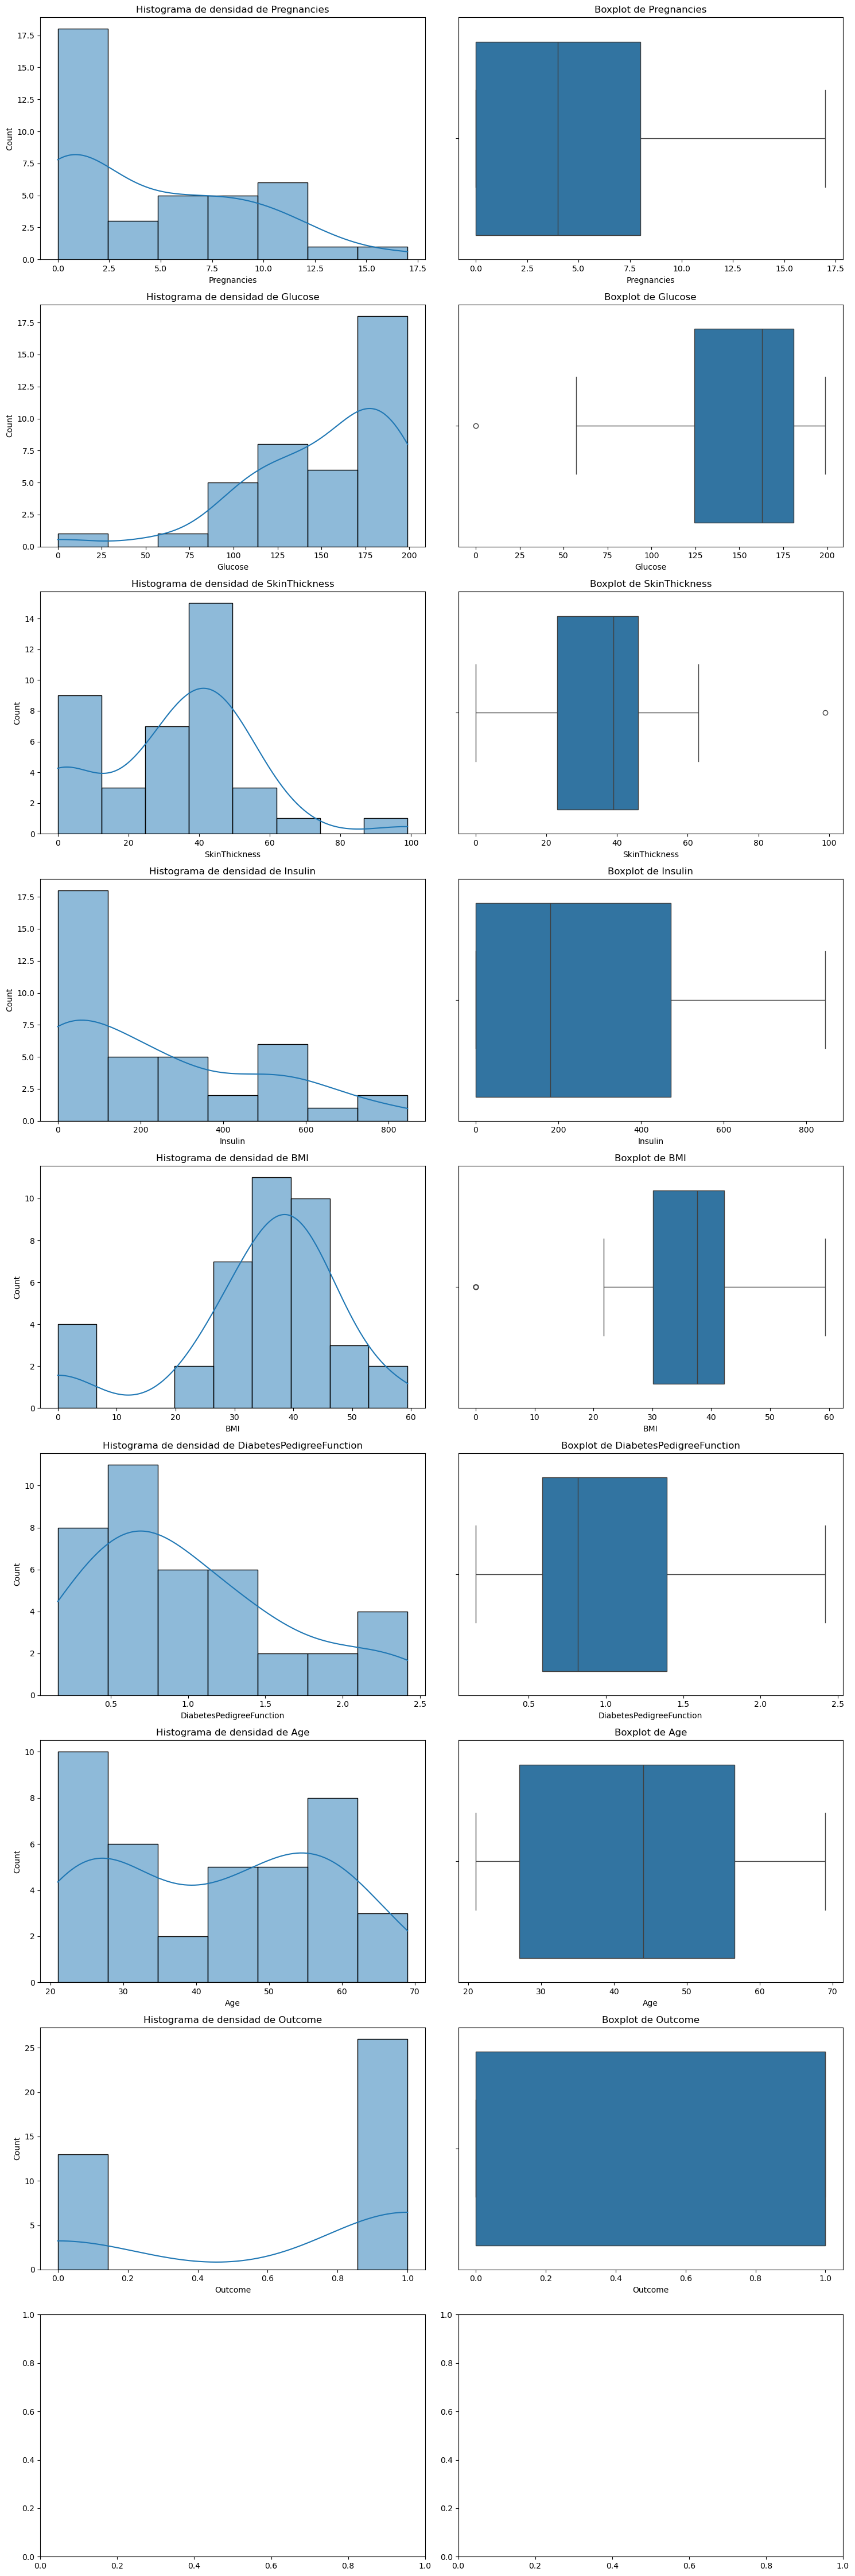

In [10]:
fig, axes = plt.subplots(nrows=len(results_filtrado.select_dtypes(include=[np.number]).columns), ncols=2, figsize=(15, 5 * len(results_filtrado.select_dtypes(include=[np.number]).columns)))

for i, column in enumerate(results_filtrado[cols_keep]):
    # Histograma de densidad
    sns.histplot(results_filtrado[column], kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f'Histograma de densidad de {column}')
    
    # Boxplot
    sns.boxplot(x=results_filtrado[column], ax=axes[i, 1])
    axes[i, 1].set_title(f'Boxplot de {column}')

plt.tight_layout()
plt.show()

Parece que el isolation forest funciona bien pero como no tenemos sufiecientes registros (quasi 800) no vamos a eliminar los 39 registros y vamos a hacer una windsorizacion de los outliers. 

## Windsorizacion

In [15]:
columnas_windsorizar = df_prepared.columns.drop(["Outcome", "Insulin"])

def windsorize_iqr(df, columns):
    """
    Applique une winsorisation basée sur l'IQR pour limiter les valeurs extrêmes.
    Les valeurs en-dessous de Q1 - 1.5*IQR et au-dessus de Q3 + 1.5*IQR sont remplacées.
    """
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
        df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
    return df

# Application
df_prepared = windsorize_iqr(df_prepared, columnas_windsorizar)


In [16]:
df_prepared["Insulin"] = np.where(df_prepared["Insulin"] > 500, 500, df_prepared["Insulin"])


# Normalizacion

In [17]:
robust_scaler = RobustScaler()
columnas_a_normalizar = df_prepared.columns.drop(["Outcome"])
df_prepared[columnas_a_normalizar] = robust_scaler.fit_transform(df_prepared[columnas_a_normalizar])

In [18]:
df_prepared.head()

,Pregnancies,Glucose,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.6,0.765432,0.857143,0.000000,0.142857,0.665359,1.235294,1
1,-0.4,-0.790123,0.000000,0.000000,-0.626374,-0.056209,0.117647,0
2,1.0,1.629630,0.000000,0.000000,-0.989011,0.783007,0.176471,1
3,-0.4,-0.691358,-0.857143,-5.391304,-0.461538,-0.537255,-0.470588,0
4,-0.6,0.493827,0.857143,7.478261,1.186813,2.163399,0.235294,1


In [19]:
OUTPUT_FOLDER = "../data/OUT/"

def save_dataframes_to_csv(output_folder, df_train, train_filename="diabetes_clean.csv"):
    """
    Guarda los DataFrames de entrenamiento y prueba en formato CSV en una carpeta específica.
    Si la carpeta ya existe, borra todo su contenido antes de guardar los nuevos archivos.
    
    Args:
        output_folder (str): La ruta de la carpeta donde se guardarán los archivos CSV.
        df_train (pd.DataFrame): El DataFrame de entrenamiento que se va a guardar.
        df_test (pd.DataFrame): El DataFrame de prueba que se va a guardar.
        train_filename (str, opcional): El nombre del archivo CSV para el DataFrame de entrenamiento.
        test_filename (str, opcional): El nombre del archivo CSV para el DataFrame de prueba.
    
    """
    # Si la carpeta ya existe, eliminar todo su contenido
    if os.path.exists(output_folder):
        shutil.rmtree(output_folder)  # Borrar toda la carpeta y su contenido
        print(f"Carpeta {output_folder} eliminada.")
    
    # Crear la carpeta si no existe
    os.makedirs(output_folder, exist_ok=True)
    
    # Definir las rutas completas de los archivos
    train_path = os.path.join(output_folder, train_filename)
    
    # Guardar los DataFrames en formato CSV
    df_train.to_csv(train_path, index=False)
    
    print(f"DataFrames guardados en {output_folder}:")
    print(f" - {train_filename}")

save_dataframes_to_csv(OUTPUT_FOLDER, df_prepared)

Carpeta ../data/OUT/ eliminada.
DataFrames guardados en ../data/OUT/:
 - diabetes_clean.csv
